# DMML-06

Kaggle; experiment tracking; custom `scikit-learn` transformers.

David Apagyi  
2025-10-16

**Web page:** <a href="https://apagyidavid.web.elte.hu/2025-2026-1/dmml"
target="_blank">apagyidavid.web.elte.hu/2025-2026-1/dmml</a>

<a target="_blank" href="https://colab.research.google.com/github/dapagyi/dmml-web/blob/notebooks/dmml-06.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle

Save your `KAGGLE_USERNAME` and `KAGGLE_KEY` in a `.env` file next to
your notebooks, like this:

```
KAGGLE_USERNAME=your_username
KAGGLE_KEY=your_key
```

In [1]:
import os

import matplotlib.pyplot as plt
import mlflow  # Install the "mlflow" package if you don't have it yet.
import numpy as np
import pandas as pd
from dotenv import load_dotenv  # Install the "python-dotenv" package if you don't have it yet.
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


load_dotenv()
print(f"KAGGLE_USERNAME={os.getenv('KAGGLE_USERNAME')}")

KAGGLE_USERNAME=dapagyi

You can download datasets from Kaggle using the `kaggle` command.
(Install the `kaggle` package if you don’t have it yet.)

In [2]:
!kaggle competitions download -c house-prices-advanced-regression-techniques -p ../data/house-prices
!unzip -o ../data/house-prices/house-prices-advanced-regression-techniques.zip -d ../data/house-prices

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ../data/house-prices/house-prices-advanced-regression-techniques.zip
  inflating: ../data/house-prices/data_description.txt  
  inflating: ../data/house-prices/sample_submission.csv  
  inflating: ../data/house-prices/test.csv  
  inflating: ../data/house-prices/train.csv  

In [3]:
df = pd.read_csv("../data/house-prices/train.csv")
df.head()

5 rows × 81 columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We will use only a few columns for simplicity.

In [5]:
selected_features = [
    "LotArea",
    "YearBuilt",
    "TotalBsmtSF",
    "Neighborhood",
    "BldgType",
    "HouseStyle",
]
target_column = "SalePrice"
df = df[[*selected_features, target_column]]

df.head()

# Experiment tracking

Some notable experiment tracking tools:

-   <a href="https://wandb.ai/site" target="_blank">Weights &amp; Biases</a>
    -   Maybe the most popular one, most user friendly.
-   <a href="https://mlflow.org/" target="_blank">MLflow</a>
    -   Open source, can be self-hosted, also works locally.
    -   There’s no “official” cloud for MLflow, but you can use
        <a href="https://dagshub.com/" target="_blank">DagsHub</a> for
        free hosting.
-   <a href="https://neptune.ai/" target="_blank">Neptune</a>
-   <a href="https://www.comet.ml/" target="_blank">Comet</a>

I prefer MLflow (I also self-host it on a server), so this showcase will
use MLflow and DagsHub, but feel free to use any other tool.

After creating a repository on DagsHub, copy your MLflow tracking URI,
username and password to your `.env` file:

```
# (...)

MLFLOW_TRACKING_USERNAME=your_username
MLFLOW_TRACKING_PASSWORD=your_tracking_password
MLFLOW_TRACKING_URI=https://dagshub.com/your_username/your_repo.mlflow
MLFLOW_EXPERIMENT_NAME="House Prices Prediction"
```

Load these environment variables into your kernel:

In [6]:
load_dotenv()
print(f"MLFLOW_TRACKING_URI={os.getenv('MLFLOW_TRACKING_URI')}")

MLFLOW_TRACKING_URI=https://dagshub.com/dapagyi/dmml.mlflow

Create a simple experiment that tracks some hyperparameters and metrics.

In [7]:
X, y = df.drop(columns=[target_column]), df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

categorical_cols = ["Neighborhood", "BldgType", "HouseStyle"]
numerical_cols = ["LotArea", "YearBuilt", "TotalBsmtSF"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
    remainder="drop",
)

preprocessor

Train set size: 1168, Test set size: 292

In [8]:
def train_and_evaluate(pipeline, param_distributions, X_train, y_train, X_test, y_test):
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        n_iter=10,
        cv=3,
        random_state=42,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    )
    mlflow.set_experiment("House Prices Prediction")
    with mlflow.start_run():
        random_search.fit(X_train, y_train)

        mlflow.log_params(random_search.best_params_)

        y_pred_train = random_search.best_estimator_.predict(X_train)
        y_pred_test = random_search.best_estimator_.predict(X_test)

        scores = cross_val_score(
            random_search.best_estimator_,
            X_train,
            y_train,
            cv=3,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1,
        )

        mlflow.log_metrics(
            {
                "cv_rmse_mean": -scores.mean(),
                "cv_rmse_std": scores.std(),
            }
        )

        mlflow.log_metrics(
            {
                "rmse_train": mean_squared_error(y_train, y_pred_train),
                "rmse_test": mean_squared_error(y_test, y_pred_test),
                "r2_train": r2_score(y_train, y_pred_train),
                "r2_test": r2_score(y_test, y_pred_test),
                "mae_train": mean_absolute_error(y_train, y_pred_train),
                "mae_test": mean_absolute_error(y_test, y_pred_test),
            }
        )

        os.makedirs("plots", exist_ok=True)

        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(y_test, y_pred_test, alpha=0.7, color="b")
        ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--r", linewidth=2)
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")
        ax.set_title("Predicted vs Actual Values")
        plot_path = "plots/prediction_plot.png"
        fig.savefig(plot_path)
        plt.close(fig)
        mlflow.log_artifact(plot_path)

        residuals = y_test - y_pred_test
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(y_pred_test, residuals, alpha=0.7, color="g")
        ax.axhline(y=0, color="r", linestyle="--", linewidth=2)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Residuals")
        ax.set_title("Residual Plot")
        residual_plot_path = "plots/residual_plot.png"
        fig.savefig(residual_plot_path)
        plt.close(fig)
        mlflow.log_artifact(residual_plot_path)

        mean_scores = -random_search.cv_results_["mean_test_score"]
        std_scores = random_search.cv_results_["std_test_score"]
        param_combinations = range(len(mean_scores))

        fig, ax = plt.subplots(figsize=(8, 6))
        ax.errorbar(
            param_combinations,
            mean_scores,
            yerr=std_scores,
            fmt="o",
            capsize=5,
            color="b",
            ecolor="r",
            elinewidth=2,
            capthick=2,
        )
        ax.set_xlabel("Parameter Combination Index")
        ax.set_ylabel("Mean RMSE (Random Search Cross-Validation)")
        ax.set_title("Random Search Cross-Validation Scores with Confidence Intervals")
        cross_val_plot_path = "plots/random_search_cross_validation_plot.png"
        fig.savefig(cross_val_plot_path)
        plt.close(fig)
        mlflow.log_artifact(cross_val_plot_path)


pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(random_state=42)),
    ]
)

param_distributions = {
    "regressor__n_estimators": np.arange(50, 300, 50),
    "regressor__max_depth": [None, 10, 20, 30, 40],
    "regressor__min_samples_split": np.arange(2, 10, 2),
    "regressor__min_samples_leaf": np.arange(1, 10, 2),
}

train_and_evaluate(pipeline, param_distributions, X_train, y_train, X_test, y_test)

🏃 View run colorful-lamb-849 at: https://dagshub.com/dapagyi/dmml.mlflow/#/experiments/0/runs/ee05223b231149f59dd262ff807b2d9e
🧪 View experiment at: https://dagshub.com/dapagyi/dmml.mlflow/#/experiments/0

# Custom `scikit-learn` transformers

In some cases, you might need to create your own custom transformers for
`scikit-learn` pipelines.

In [9]:
df.head()

Let’s say we want to create a transformer that adds a new feature: the
age of the house at the time of sale. We can create a custom transformer
by inheriting from `BaseEstimator` and `TransformerMixin`:

In [10]:
from datetime import datetime

from sklearn.base import BaseEstimator, TransformerMixin


class DateDiffTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, current_year=None):
        self.current_year = current_year if current_year is not None else datetime.now().year

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        _X = X.copy()
        _X["HouseAge"] = self.current_year - _X["YearBuilt"]
        return _X[["HouseAge"]]


display(df.head())
transformer = DateDiffTransformer()
transformed_df = transformer.fit_transform(df)
display(transformed_df.head())

Now we can integrate this custom transformer into our existing pipeline.

In [11]:
year_built_col = "YearBuilt"
numerical_cols.remove(year_built_col)

preprocessor = ColumnTransformer(
    transformers=[
        ("year", DateDiffTransformer(), [year_built_col]),
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
    remainder="drop",
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(random_state=42)),
    ]
)

pipeline

In [12]:
train_and_evaluate(pipeline, param_distributions, X_train, y_train, X_test, y_test)

🏃 View run capable-chimp-695 at: https://dagshub.com/dapagyi/dmml.mlflow/#/experiments/0/runs/1eeb9dd89ed546138ad1fe719e4668dc
🧪 View experiment at: https://dagshub.com/dapagyi/dmml.mlflow/#/experiments/0

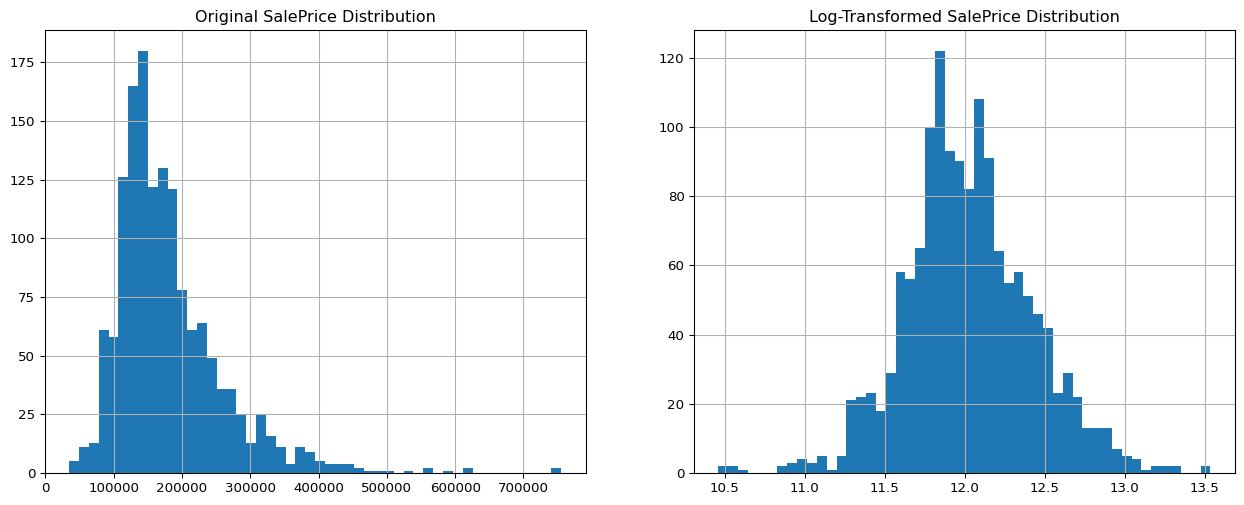

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
df[target_column].hist(bins=50, ax=ax[0])
np.log(df[target_column]).hist(bins=50, ax=ax[1])
ax[0].set_title("Original SalePrice Distribution")
ax[1].set_title("Log-Transformed SalePrice Distribution")
plt.show()

Extend the pipeline to include a log transformation of the target
variable.

In [14]:
from sklearn.compose import TransformedTargetRegressor


pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(random_state=42)),
    ]
)

pipeline = TransformedTargetRegressor(
    regressor=pipeline,
    func=np.log1p,  # log(1 + x) to handle zero values
    inverse_func=np.expm1,  # exp(x) - 1 to revert the transformation
)

param_distributions = {
    "regressor__regressor__n_estimators": np.arange(50, 300, 50),
    "regressor__regressor__max_depth": [None, 10, 20, 30, 40],
    "regressor__regressor__min_samples_split": np.arange(2, 10, 2),
    "regressor__regressor__min_samples_leaf": np.arange(1, 10, 2),
}

train_and_evaluate(pipeline, param_distributions, X_train, y_train, X_test, y_test)

🏃 View run amusing-gnu-235 at: https://dagshub.com/dapagyi/dmml.mlflow/#/experiments/0/runs/23e61b3bf2c2464ba3d60903d8596475
🧪 View experiment at: https://dagshub.com/dapagyi/dmml.mlflow/#/experiments/0

Useful links:

-   <a
    href="https://scikit-learn.org/stable/modules/compose.html#transforming-target-in-regression"
    target="_blank">Transforming target in regression</a>
-   <a
    href="https://scikit-learn.org/stable/modules/preprocessing.html#custom-transformers"
    target="_blank">Custom transformers</a>
-   <a
    href="https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer.html"
    target="_blank">Column Transformer with Heterogeneous Data Sources</a>